In [8]:
import os
from os import path

LABELS_DIR = "labels"
DATA_DIR = "data"
AUG_DIR = "aug"

if path.exists(AUG_DIR):
    os.rmdir(AUG_DIR)

for root, dirs, files in os.walk(DATA_DIR):
    for dir in dirs:
        new_root = f"{AUG_DIR}/{root[5:]}/{dir}"
        if not path.exists(new_root):
           os.makedirs(new_root)

In [9]:
import os
from os import path

import torch
from torch.utils.data import Dataset
import torchvision.io as io
import pandas as pd


class OCRDataset(Dataset):
    def __init__(self, dataset_dir, labels_dir, transform, device=None):
        self.dataset_dir = dataset_dir
        self.labels_dir = labels_dir
        self.transform = transform
        self.device = device
        self.df = self.build_df()

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get file name + text
        file_name = self.df["file_name"][idx]
        # prepare image (i.e. resize + normalize)
        # img = io.read_image(
        #     path.join(self.dataset_dir, file_name))
        # if self.device:
        #     img.to(self.device)
        # if self.transform:
        #     img = self.transform(img)
        # return (file_name, img)
        text = self.df["text"][idx]
        return (file_name, text)

    def build_df(self):
        li = []
        for root, dirs, files in os.walk(self.labels_dir):
            for file in files:  # Loop through the dataset tsvfiles
                if not file.endswith(".tsv"):
                    continue

                print(f"Processing {file}")
                li.append(pd.read_table(path.join(root, file),
                          names=["file_name", "text"]))

        return pd.concat(li, axis=0, ignore_index=True)

In [10]:
import torch

import torchvision.transforms.v2 as transforms
from torchvision.transforms.v2 import InterpolationMode

LABELS_DIR = "dataset/labels"
DATA_DIR = "dataset/data"
AUG_DIR = "dataset/aug"

transform = transforms.Compose([
    transforms.Resize(
        (64, 1024), interpolation=InterpolationMode.BILINEAR, antialias=True),
])

dataset = OCRDataset(DATA_DIR, LABELS_DIR,
                     transform=None, device=torch.device("cuda"))

Processing hw_chinese_240k.tsv
Processing hwdb_ic13_47k.tsv
Processing hwdb2.1_13k.tsv
Processing hwdb2.2_12k.tsv
Processing hwdb2.0_16k.tsv
Processing hand_line_all_548k.tsv
Processing signatures_472k.tsv
Processing web_line_238k.tsv
Processing hwdb2.0_4k.tsv
Processing hwdb_ic13_3k.tsv
Processing hw_chinese_17k.tsv
Processing hwdb2.2_3k.tsv
Processing hwdb2.1_3k.tsv
Processing hwdb_ic13_val_5k.tsv
Processing test_niandai.tsv
Processing hwdb_ic13_3k.tsv


In [11]:
from os import path
import torch
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from tqdm import tqdm

from data_aug import build_data_aug

DATA_DIR = "data"
LABELS_DIR = "labels"
AUG_DIR = "aug"


device = torch.device("cuda")

batch_size = 256
data_loader = DataLoader(dataset, batch_size=batch_size)

transform = build_data_aug((64, 1024), "train", device=device)

for batch in tqdm(data_loader):
    for (file_name, text) in zip(*batch):
        if not isinstance(text, str):
            print(file_name)

    # input_images = batch[1]
    # transformed_batch = transform(input_images.to(device))
    # for i, item in enumerate(transformed_batch):
    #     img = item
    #     save_image(img, path.join(AUG_DIR, batch[0][i]))


In [ ]:
import os
from os import path

import torch
from tqdm import tqdm
import torchvision
import torchvision.io as io
from data_aug import build_data_aug


LABELS_DIR = "dataset/labels"
DATA_DIR = "dataset/data"
AUG_DIR = "dataset/aug"

# device = torch.device("cuda")
# tfm = build_data_aug(64, "train", device=device)

for root, dirs, files in os.walk(LABELS_DIR):
    for file in files:  # Loop through the dataset tsvfiles
        if not file.endswith(".tsv"):
            continue

        print(f"Processing {file}")

        with open(path.join(root, file), "r", encoding="utf-8") as tsvfile:

            for line in tqdm(tsvfile):  # Loop through lines in the tsvfile
                if not line:
                    continue

                image_file = line.split("\t")[0]
                image_path = path.join(DATA_DIR, image_file)
                if not path.exists(image_path):
                    raise Exception(f"Image file {image_file} not found")

                # aug_dir = path.join(AUG_DIR, "/".join(image_file.split("/")[:-1]))
                # if not path.exists(aug_dir):
                #     os.makedirs(aug_dir)

                # input_image = io.read_image(path.join(DATA_DIR, image_file))
                # augmented = tfm(input_image.to(device))

                # output_path = path.join(AUG_DIR, image_file)
                # torchvision.utils.save_image(augmented, output_path)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:16                                                                                   │
│                                                                                                  │
│   13 AUG_DIR = "dataset/aug"                                                                     │
│   14                                                                                             │
│   15 device = torch.device("cuda")                                                               │
│ ❱ 16 tfm = build_data_aug(64, "train", device=device)                                            │
│   17                                                                                             │
│   18 for root, dirs, files in os.walk(LABELS_DIR):                                               │
│   19 │   for file in files:  # Loop through the dataset tsvfiles                                 │
│                                                                                                  │
│ /home/dotin13/mijo/GitHub/hand-syn/tang-syn/data_aug.py:217 in build_data_aug                    │
│                                                                                                  │
│   214 │   │   │   transforms.ConvertImageDtype(dtype=torch.float32),                             │
│   215 │   │   │   transforms.RandomChoice([                                                      │
│   216 │   │   │   │   # WeightedRandomChoice([                                                   │
│ ❱ 217 │   │   │   │   # transforms.RandomHorizontalFlip(p=1),                                    │
│   218 │   │   │   │   transforms.RandomRotation(degrees=(-10, 10),                               │
│   219 │   │   │   │   │   │   │   │   │   │     expand=True,                                     │
│   220 │   │   │   │   │   │   │   │   │   │     fill=(1, 1, 1)),                                 │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
TypeError: 'int' object is not subscriptable

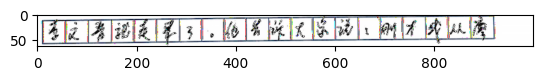

In [ ]:
"""V2 Testing"""

from torchvision.transforms import functional

import torch
import torchvision.io as io
from numpy import asarray
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter
from data_aug_v2 import build_data_aug

# device = torch.device("cuda")
# input_image = io.read_image("sample_imgs/0.png").unsqueeze(0).to(device)
input_image = Image.open("samples/images/0.png").convert("RGB")
tfm = build_data_aug(width=1000, mode="train", resizepad=True)
augmented = tfm(input_image)

# plt.imshow(functional.to_pil_image(augmented.cpu()[0]))

# input_image = input_image.filter(ImageFilter.MinFilter(3))
plt.imshow(augmented)
plt.show()

In [ ]:
"""V1 Testing"""

from torchvision.transforms import functional

import torch
import torchvision.io as io
from numpy import asarray
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter
from data_aug import build_data_aug

input_image = Image.open("0.png")
tfm = build_data_aug(64, "train")
augmented = tfm(input_image)

# plt.imshow(functional.to_pil_image(augmented.cpu()[0]))

# plt.imshow(augmented.cpu())

plt.imshow(functional.to_pil_image(augmented))

# input_image = input_image.filter(ImageFilter.MinFilter(3))
# plt.imshow(input_image)
plt.show()